In [2]:
import torch
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

CUDA is not available.  Training on CPU ...


device(type='cpu')

In [3]:
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torchsummary import summary
import matplotlib.pyplot as plt

# number of subprocesses to use for data loading
num_workers = 2
# how many samples per batch to load
batch_size = 500

# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(10, fill=(0,)),
    #transforms.RandomPerspective(),
    #transforms.RandomAffine(10),
    ])

transform_val = transforms.Compose([
    transforms.ToTensor(),

    ])

# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform_train)
val_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform_val)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform_val)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
#np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [4]:
import torch.nn as nn
import torch.nn.functional as F
# define the CNN architecture

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.network=nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=(1,1),padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(16,affine = False), #2
            nn.Conv2d(16, 16, kernel_size=3, stride=(1,1),padding='same'), 
            nn.ReLU(), 
            nn.BatchNorm2d(16,affine = False), #5
            nn.MaxPool2d(2, 2), #6
            nn.Conv2d(16, 32, kernel_size=3, stride=(1,1),padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(32,affine = False), #9
            nn.Conv2d(32, 32, kernel_size=3, stride=(1,1),padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(32,affine = False), #12
            nn.MaxPool2d(2, 2), #13
            nn.Conv2d(32, 64, kernel_size=3, stride=(1,1),padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(64,affine = False), #16
            nn.Conv2d(64, 64, kernel_size=3, stride=(1,1),padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(64,affine = False), #19
            nn.MaxPool2d(2, stride=(2,2)), #20
            nn.Conv2d(64, 128, kernel_size=3, stride=(1,1),padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(128,affine = False), #23
            nn.Conv2d(128, 128, kernel_size=3, stride=(1,1),padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(128,affine = False), #26
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(128, 10))

    def forward(self, x):
        x = self.network(x)
        return x
# create a complete CNN
model = Net()
# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

In [5]:
summary(model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
              ReLU-2           [-1, 16, 32, 32]               0
       BatchNorm2d-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 16, 32, 32]           2,320
              ReLU-5           [-1, 16, 32, 32]               0
       BatchNorm2d-6           [-1, 16, 32, 32]               0
         MaxPool2d-7           [-1, 16, 16, 16]               0
            Conv2d-8           [-1, 32, 16, 16]           4,640
              ReLU-9           [-1, 32, 16, 16]               0
      BatchNorm2d-10           [-1, 32, 16, 16]               0
           Conv2d-11           [-1, 32, 16, 16]           9,248
             ReLU-12           [-1, 32, 16, 16]               0
      BatchNorm2d-13           [-1, 32, 16, 16]               0
        MaxPool2d-14             [-1, 3

In [6]:
import torch.optim as optim
# specify loss function
criterion = nn.CrossEntropyLoss()
# specify optimizer
lr = 0.001
weight_decay=0
optimizer = optim.Adam(model.parameters(), lr=lr)
optimizer_name = 'Adam'

In [7]:
# number of epochs to train the model
n_epochs = 50
#List to store loss to visualize
train_losslist = []
valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    correct= 0
    total=0
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
    cur_val_acc = correct / total
    train_losslist.append(train_loss)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tValidation Accuracy:{:.6f}'.format(
        epoch, train_loss, valid_loss,cur_val_acc))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar_2b.h5')
        valid_loss_min = valid_loss



Epoch: 1 	Training Loss: 111.572855 	Validation Loss: 26.566355 	Validation Accuracy:0.510500
Validation loss decreased (inf --> 26.566355).  Saving model ...
Epoch: 2 	Training Loss: 95.189977 	Validation Loss: 23.971695 	Validation Accuracy:0.568700
Validation loss decreased (26.566355 --> 23.971695).  Saving model ...
Epoch: 3 	Training Loss: 86.654131 	Validation Loss: 22.129900 	Validation Accuracy:0.607400
Validation loss decreased (23.971695 --> 22.129900).  Saving model ...
Epoch: 4 	Training Loss: 80.369180 	Validation Loss: 20.403913 	Validation Accuracy:0.636300
Validation loss decreased (22.129900 --> 20.403913).  Saving model ...
Epoch: 5 	Training Loss: 76.937255 	Validation Loss: 19.444969 	Validation Accuracy:0.651700
Validation loss decreased (20.403913 --> 19.444969).  Saving model ...
Epoch: 6 	Training Loss: 72.362763 	Validation Loss: 18.786343 	Validation Accuracy:0.669200
Validation loss decreased (19.444969 --> 18.786343).  Saving model ...
Epoch: 7 	Training Lo

In [9]:
net = Net().to(device)
net.load_state_dict(torch.load('model_cifar_2b.h5'))
net.eval()
total=0
correct =0
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = net(data)
    # calculate the batch loss
    loss = criterion(output, target)
    _, predicted = torch.max(output.data, 1)
    total += target.size(0)
    correct += (predicted == target).sum().item()
test_acc = correct / total
print(test_acc)

0.8378


In [29]:
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.models.feature_extraction import get_graph_node_names
images, labels = iter(train_loader).next()
image_example = images
exact_list={f'network.{k}': str(v) for v, k in enumerate([0,1, 2, 3, 4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29])}
device="cpu"
model = model.to(device)
feature_extractor = create_feature_extractor(model,exact_list)
x=feature_extractor(image_example)



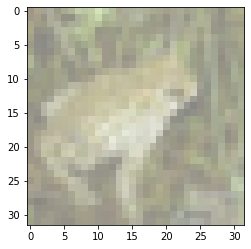

In [30]:
import matplotlib.pyplot as plt

images = image_example.numpy()
fig = plt.figure(figsize=(25, 4))
images=images/2+0.5
img=np.transpose(images[0], (1, 2, 0))
plt.imshow(img)

In [53]:
normalized_layers=['1','4','5','8','11','12','15','18','19','22','25','26']
relu_layers=      ['0','3','5','7','8','10','12','14','17','19','21','24','26']
total_layers=['0','1','3','4','5','7','8','10','11','12','14','15','17','18','19','21','22','24','25','26']

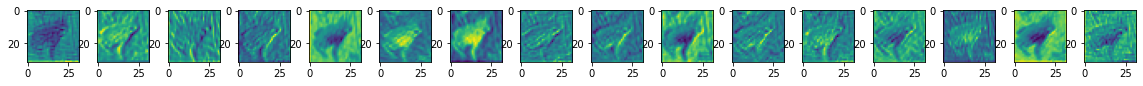

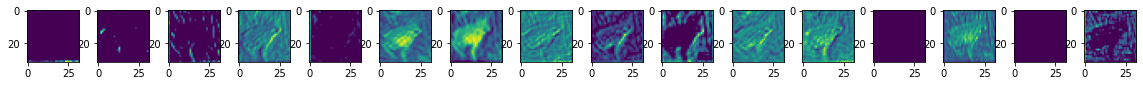

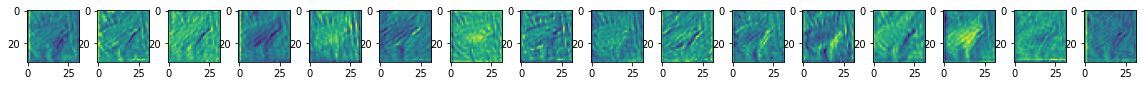

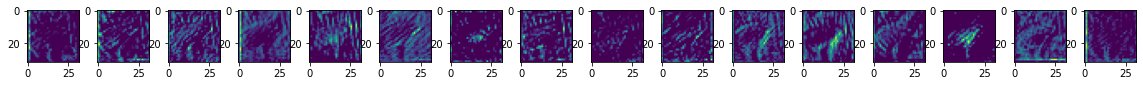

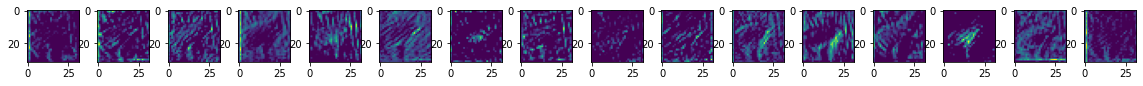

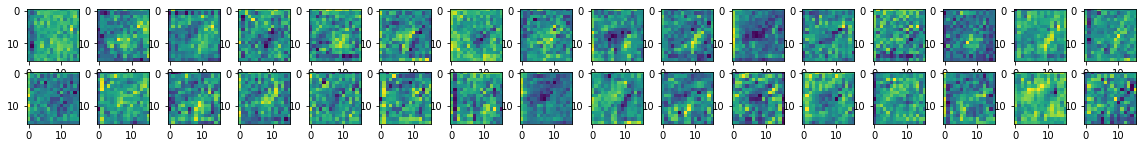

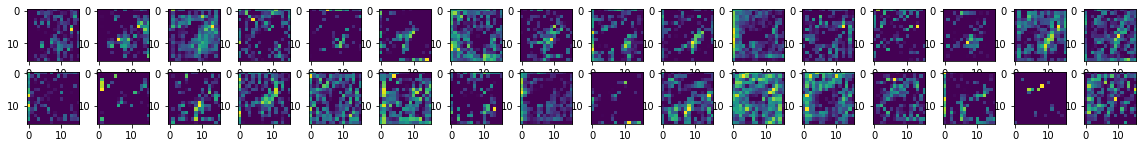

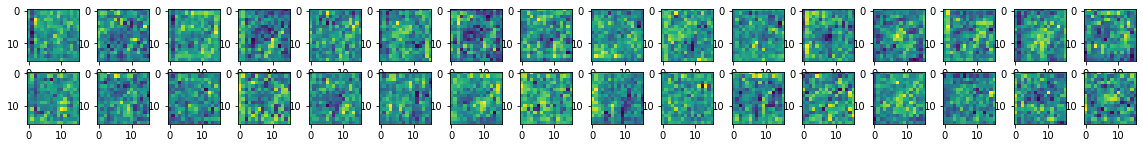

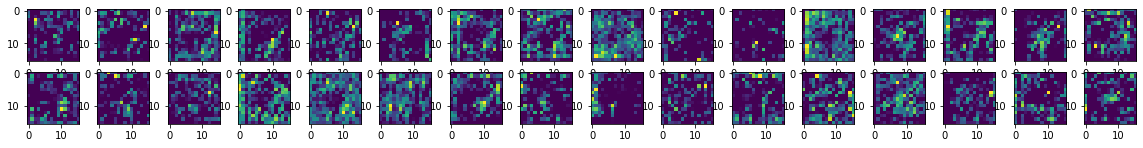

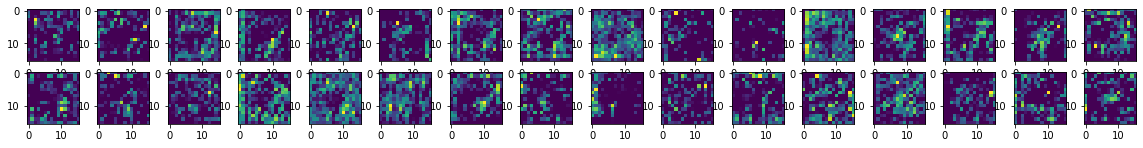

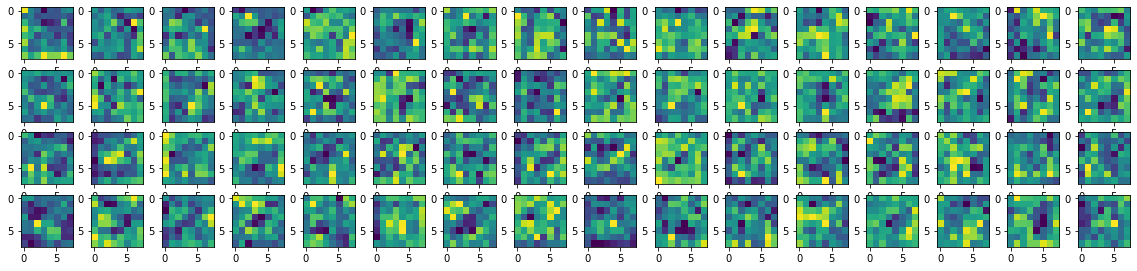

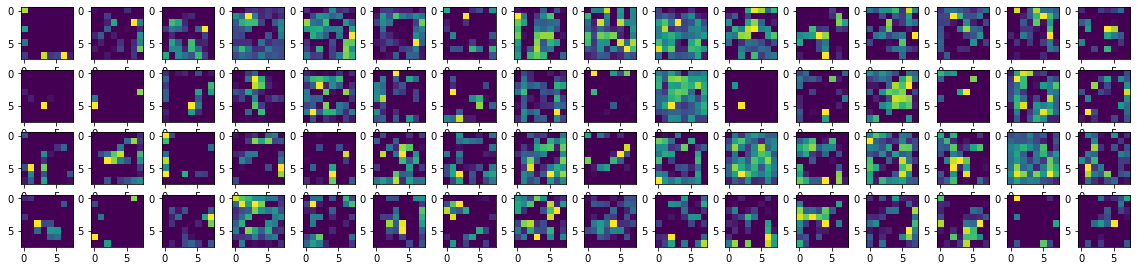

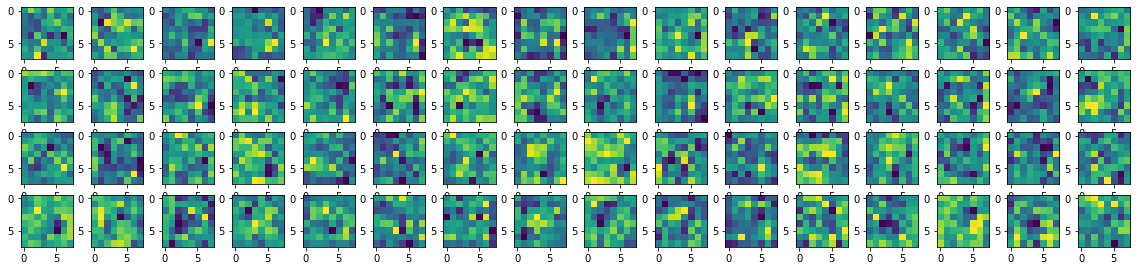

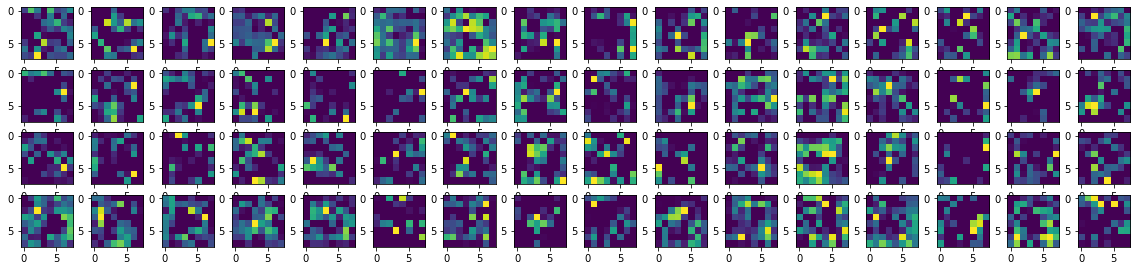

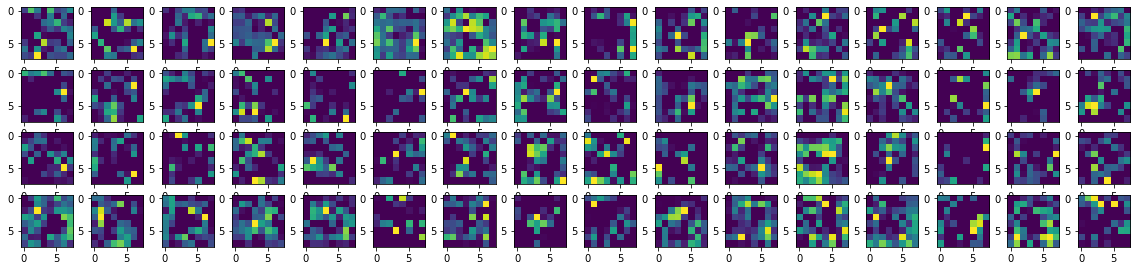

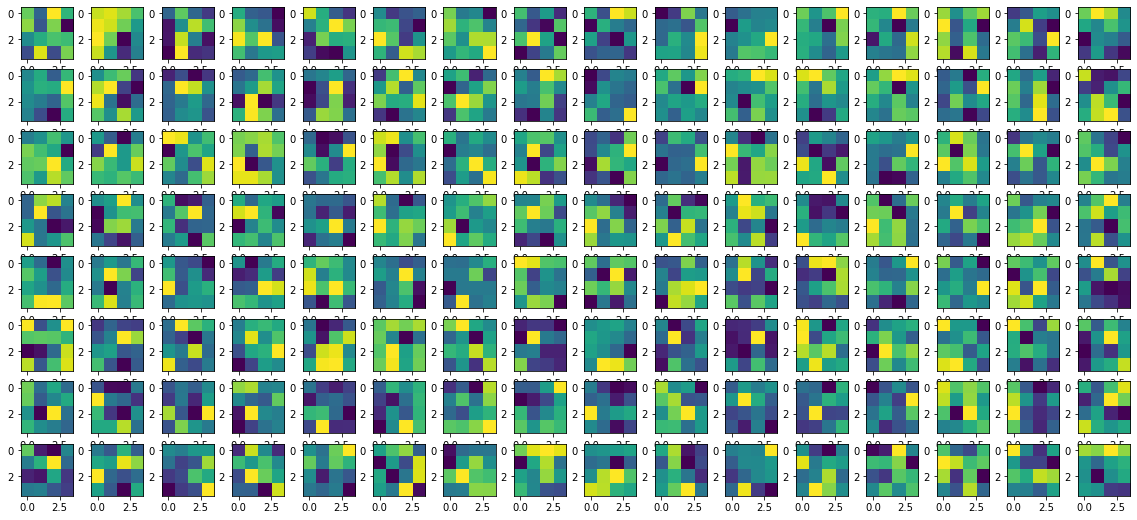

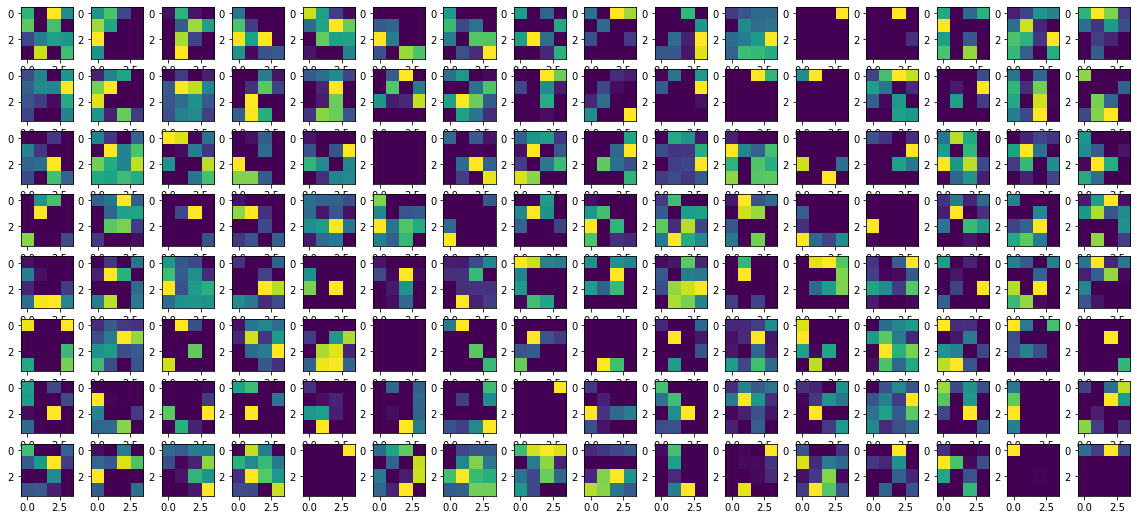

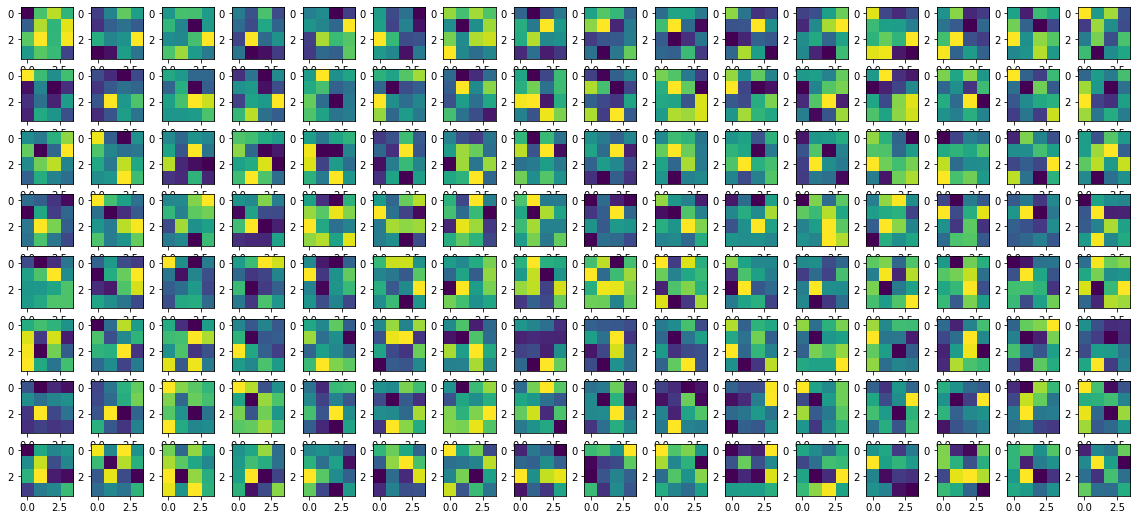

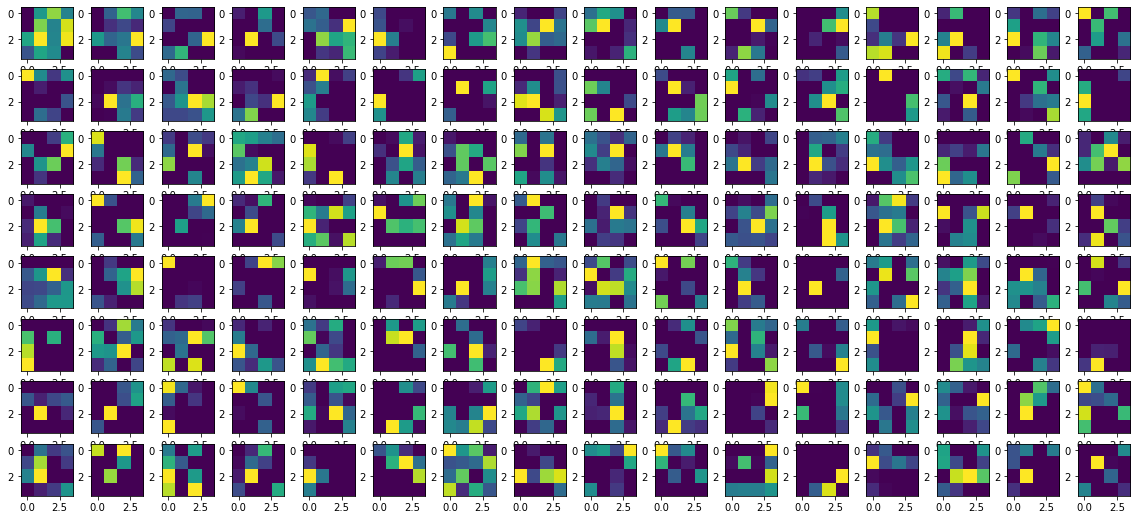

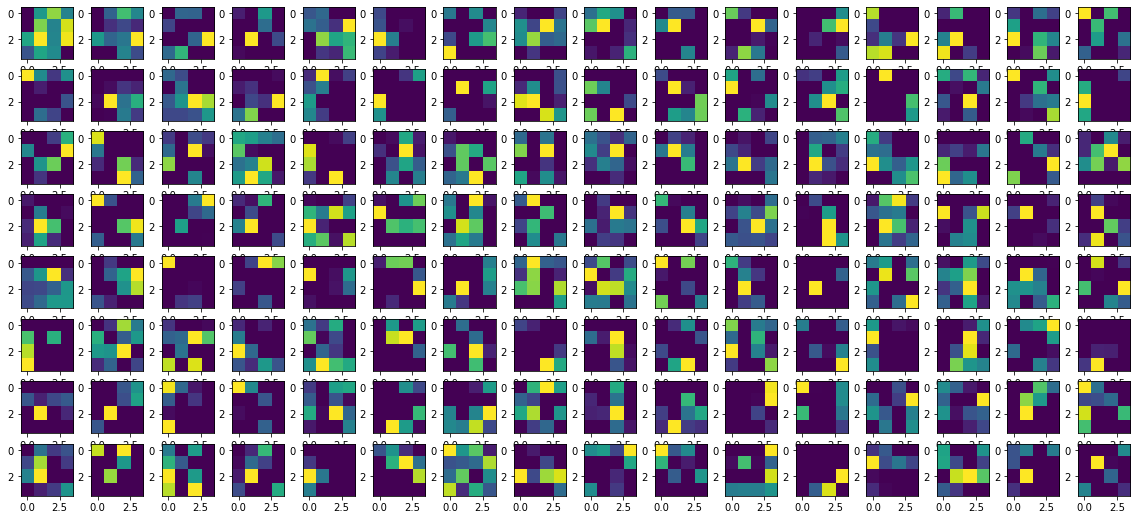

In [58]:
for l in total_layers: 
    layer=x[l].detach().numpy()
    plt.figure(figsize=(20,9))
    #print(layer)
    for i,item in enumerate(layer[0]):
        plt.subplot(8, 16, i + 1)
        plt.imshow(layer[0,i,:,:])
    #plt.title('11111111111')

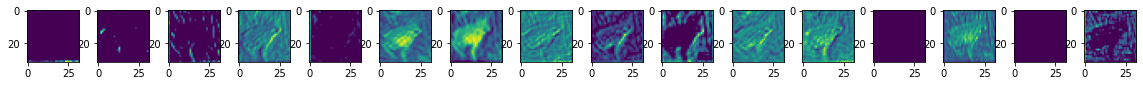

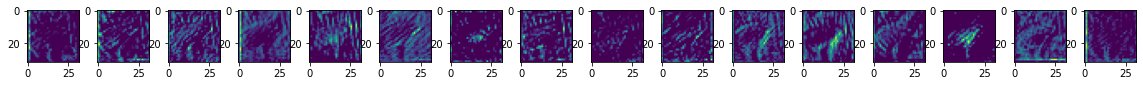

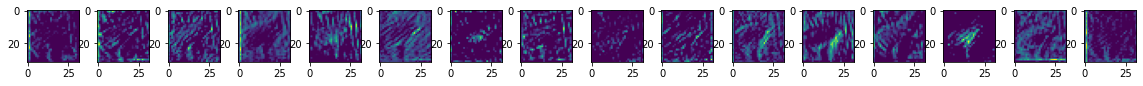

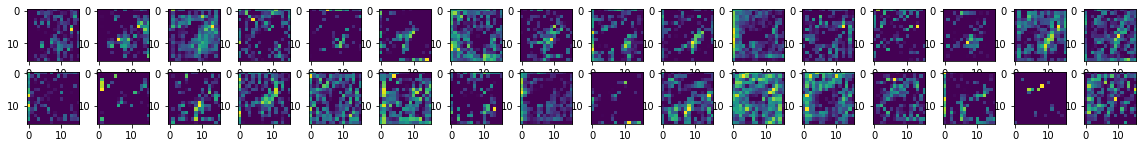

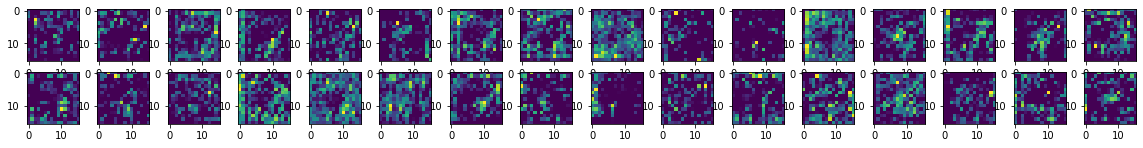

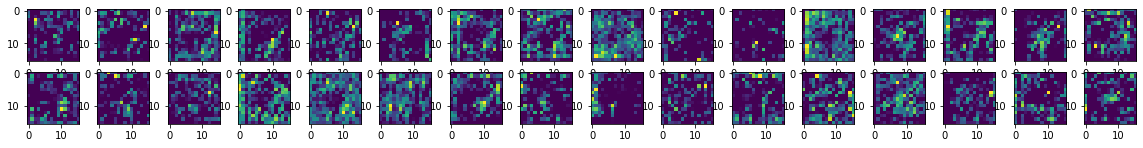

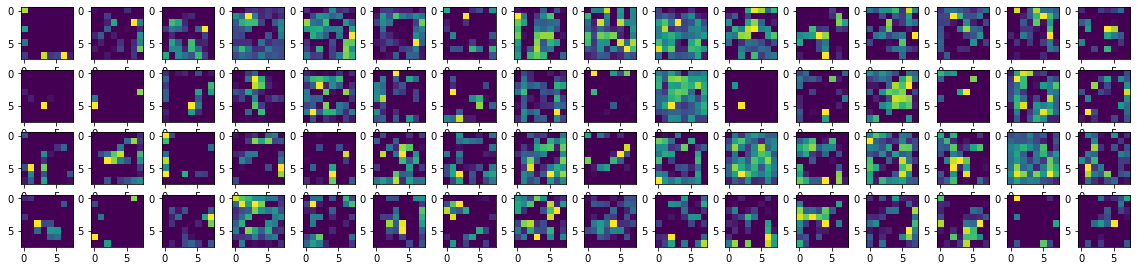

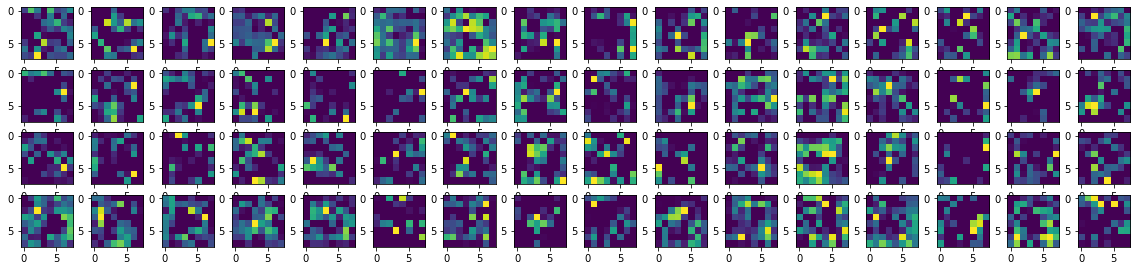

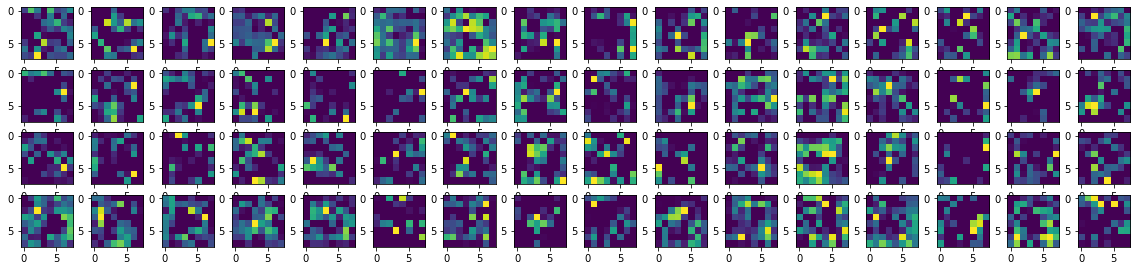

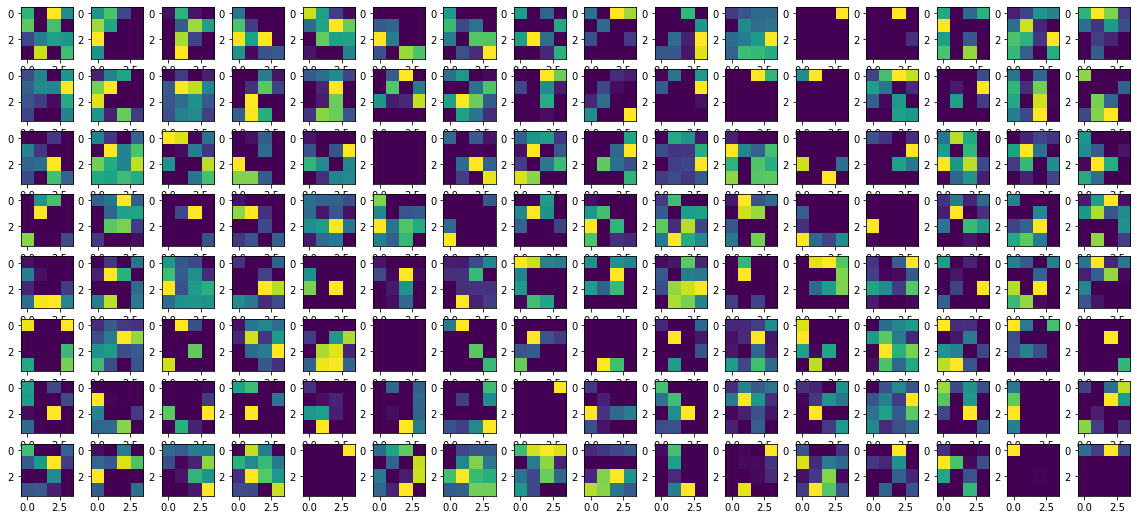

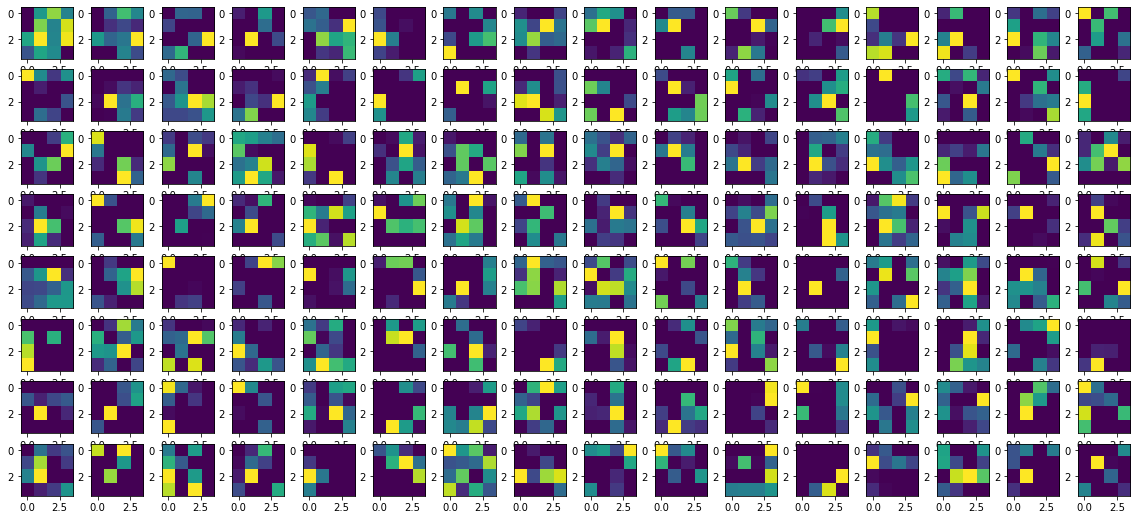

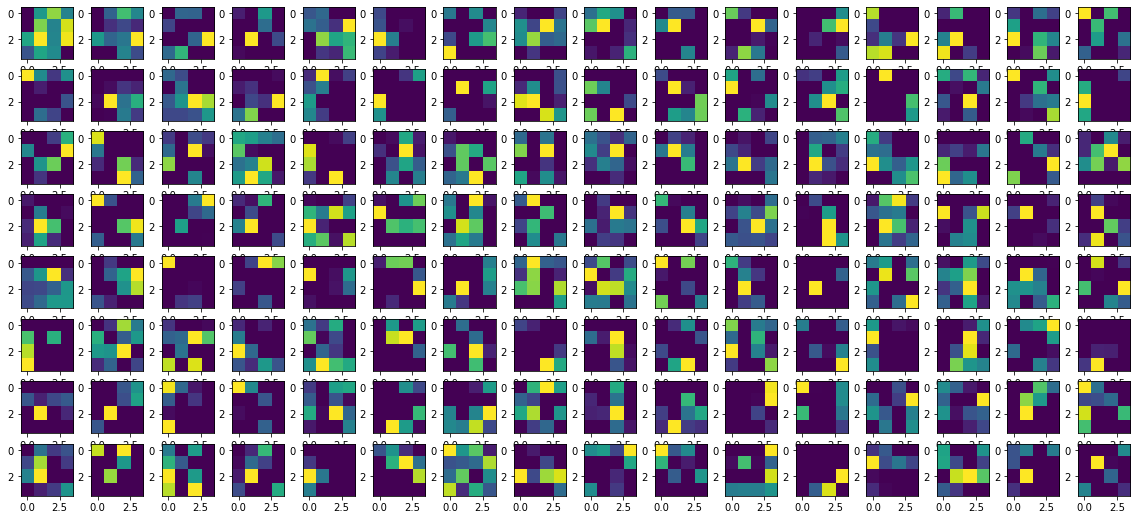

In [59]:
for l in normalized_layers: 
    layer=x[l].detach().numpy()
    plt.figure(figsize=(20,9))
    #print(layer)
    for i,item in enumerate(layer[0]):
        plt.subplot(8, 16, i + 1)
        plt.imshow(layer[0,i,:,:])
    #plt.title('11111111111')

In [56]:
abs_avgs = []
for l in normalized_layers: 
    layer=x[l].detach().numpy()
    abs_avgs.append(np.mean(np.absolute(layer)))
abs_avgs

[0.10260193,
 0.16924374,
 0.7149261,
 0.25726974,
 0.21578869,
 0.7582396,
 0.29101837,
 0.2062005,
 0.7620825,
 0.30821952,
 0.19216308,
 0.76441413]